In [2]:
print("1. IMPORTING LIBRARIES")
# Basic
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Explainability
import shap


1. IMPORTING LIBRARIES


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
print("2. LOAD AND INSPECT DATASET")
# Load dataset (replace path if needed)
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Overview
print(df.shape)
df.head()
df.info()


2. LOAD AND INSPECT DATASET
(7043, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  Pap

In [8]:
print("3. DATA CLEANING")
# Remove customerID (not useful for prediction)
df.drop('customerID', axis=1, inplace=True)

# Convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Handle missing values
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# Check duplicates
df.drop_duplicates(inplace=True)

# Encode target
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})


3. DATA CLEANING


KeyError: "['customerID'] not found in axis"

In [4]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn
count,7021.000000,7021.000000,7021.000000,7021.000000,7021.000000
mean,0.162512,32.469449,64.851894,2288.954490,0.264492
std,0.368947,24.534965,30.069001,2265.319449,0.441094
min,0.000000,0.000000,18.250000,18.800000,0.000000
25%,0.000000,9.000000,35.750000,411.150000,0.000000
50%,0.000000,29.000000,70.400000,1400.550000,0.000000
75%,0.000000,55.000000,89.900000,3801.700000,1.000000
max,1.000000,72.000000,118.750000,8684.800000,1.000000


3.1 NUMERICAL SUMMARY STATISTICS
Numerical columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']


,count,mean,std,min,25%,50%,75%,max,missing
SeniorCitizen,7021.0,0.162512,0.368947,0.00,0.00,0.00,0.0,1.00,0
tenure,7021.0,32.469449,24.534965,0.00,9.00,29.00,55.0,72.00,0
MonthlyCharges,7021.0,64.851894,30.069001,18.25,35.75,70.40,89.9,118.75,0
TotalCharges,7021.0,2288.954490,2265.319449,18.80,411.15,1400.55,3801.7,8684.80,0
Churn,7021.0,0.264492,0.441094,0.00,0.00,0.00,1.0,1.00,0


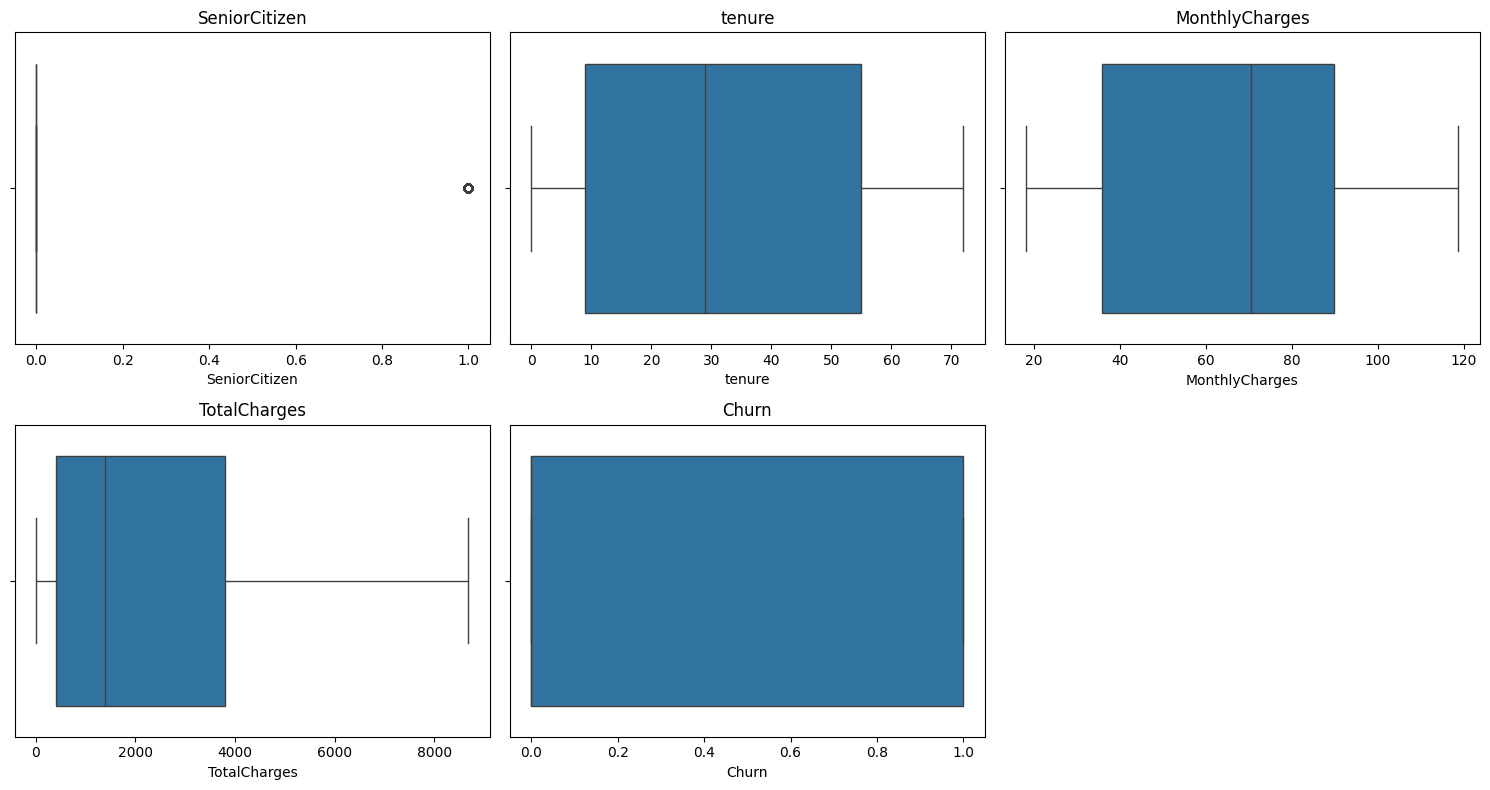

In [5]:
print("3.1 NUMERICAL SUMMARY STATISTICS")
from IPython.display import display
# Select numeric columns
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numerical columns:", num_cols)

# Summary statistics with missing counts
num_stats = df[num_cols].describe().T
num_stats['missing'] = df[num_cols].isna().sum()
display(num_stats)

# Boxplots for each numerical column
import math
n = len(num_cols)
cols = 3
rows = math.ceil(n / cols)
plt.figure(figsize=(cols*5, rows*4))
for i, col in enumerate(num_cols, 1):
    plt.subplot(rows, cols, i)
    sns.boxplot(x=df[col])
    plt.title(col)
    plt.tight_layout()
plt.show()

In [6]:
print("4. ENCODING AND SCALING")
# Label encode categorical features
cat_cols = df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Scale numerical features
scaler = StandardScaler()
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[num_cols] = scaler.fit_transform(df[num_cols])


4. ENCODING AND SCALING


In [7]:
print("5. FEATURE ENGINEERING (enhance with time-like logic)")
# Create tenure category
df['TenureGroup'] = pd.cut(df['tenure'], bins=[0, 12, 24, 48, 72], labels=['<1yr', '1-2yr', '2-4yr', '4-6yr'])

# Encode the new feature
df = pd.get_dummies(df, columns=['TenureGroup'], drop_first=True)

# Derived feature: average monthly spend per tenure
df['AvgMonthlySpend'] = df['TotalCharges'] / (df['tenure'] + 1)

# Replace inf/nan
df.replace([np.inf, -np.inf], 0, inplace=True)
df.fillna(0, inplace=True)

df.info()

5. FEATURE ENGINEERING (enhance with time-like logic)
<class 'pandas.core.frame.DataFrame'>
Index: 7021 entries, 0 to 7042
Data columns (total 35 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   SeniorCitizen                          7021 non-null   int64  
 1   tenure                                 7021 non-null   float64
 2   MonthlyCharges                         7021 non-null   float64
 3   TotalCharges                           7021 non-null   float64
 4   Churn                                  7021 non-null   int64  
 5   gender_Male                            7021 non-null   bool   
 6   Partner_Yes                            7021 non-null   bool   
 7   Dependents_Yes                         7021 non-null   bool   
 8   PhoneService_Yes                       7021 non-null   bool   
 9   MultipleLines_No phone service         7021 non-null   bool   
 10  MultipleLines_Yes      

6. FEATURE SELECTION
AvgMonthlySpend                   0.154355
TotalCharges                      0.149377
MonthlyCharges                    0.141089
tenure                            0.139346
InternetService_Fiber optic       0.036832
PaymentMethod_Electronic check    0.031252
Contract_Two year                 0.029092
gender_Male                       0.024056
OnlineSecurity_Yes                0.023611
PaperlessBilling_Yes              0.023278
dtype: float64
AvgMonthlySpend                   0.154355
TotalCharges                      0.149377
MonthlyCharges                    0.141089
tenure                            0.139346
InternetService_Fiber optic       0.036832
PaymentMethod_Electronic check    0.031252
Contract_Two year                 0.029092
gender_Male                       0.024056
OnlineSecurity_Yes                0.023611
PaperlessBilling_Yes              0.023278
dtype: float64


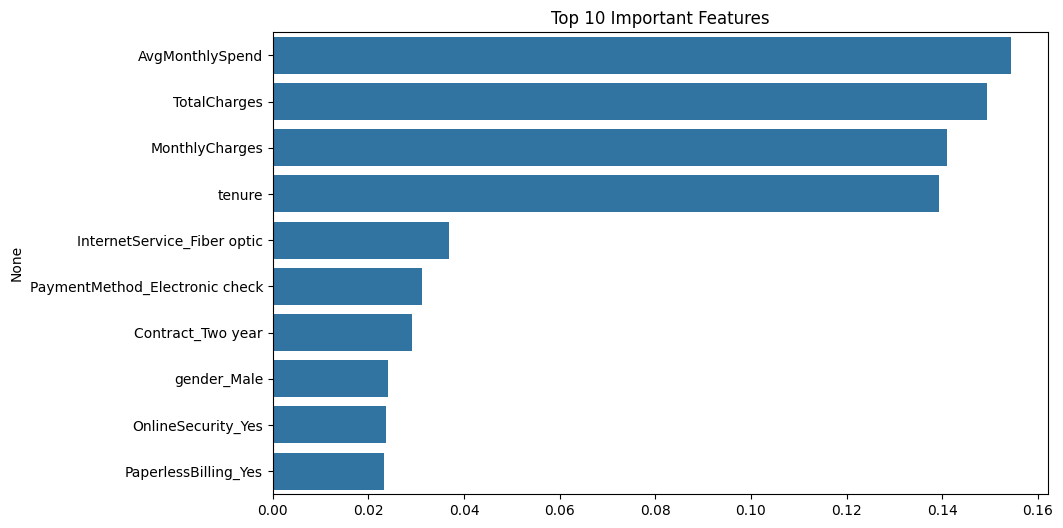

In [19]:
print("6. FEATURE SELECTION")
# Feature importance using RandomForest
X = df.drop('Churn', axis=1)
y = df['Churn']

rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
top_features = importances.head(10)
print(top_features)

# Visualize
plt.figure(figsize=(10,6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Top 10 Important Features")
plt.show()


In [9]:
print("7. SPLIT DATA")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


7. SPLIT DATA


In [10]:
print("8. MODEL TRAINING AND TUNING")
models = {
    "Logistic Regression": LogisticRegression(max_iter=300),
    "Decision Tree": DecisionTreeClassifier(max_depth=8, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=12, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=300, learning_rate=0.1, max_depth=6, subsample=0.8, colsample_bytree=0.8, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_proba)
    }

results_df = pd.DataFrame(results).T
print(results_df)


8. MODEL TRAINING AND TUNING
                     Accuracy  Precision    Recall        F1   ROC-AUC
Logistic Regression  0.792883   0.595016  0.542614  0.567608  0.846356
Decision Tree        0.767260   0.535817  0.531250  0.533524  0.776744
Random Forest        0.798577   0.621908  0.500000  0.554331  0.832535
XGBoost              0.779359   0.568182  0.497159  0.530303  0.811132
                     Accuracy  Precision    Recall        F1   ROC-AUC
Logistic Regression  0.792883   0.595016  0.542614  0.567608  0.846356
Decision Tree        0.767260   0.535817  0.531250  0.533524  0.776744
Random Forest        0.798577   0.621908  0.500000  0.554331  0.832535
XGBoost              0.779359   0.568182  0.497159  0.530303  0.811132


9. ROC Curve Visualization


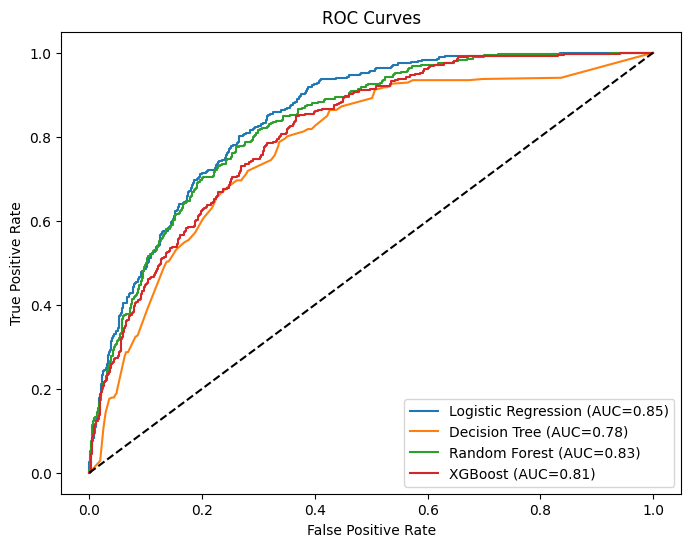

In [11]:
print("9. ROC Curve Visualization")
plt.figure(figsize=(8,6))
for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test, y_proba):.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()


10. MODEL EXPLAINABILITY WITH SHAP


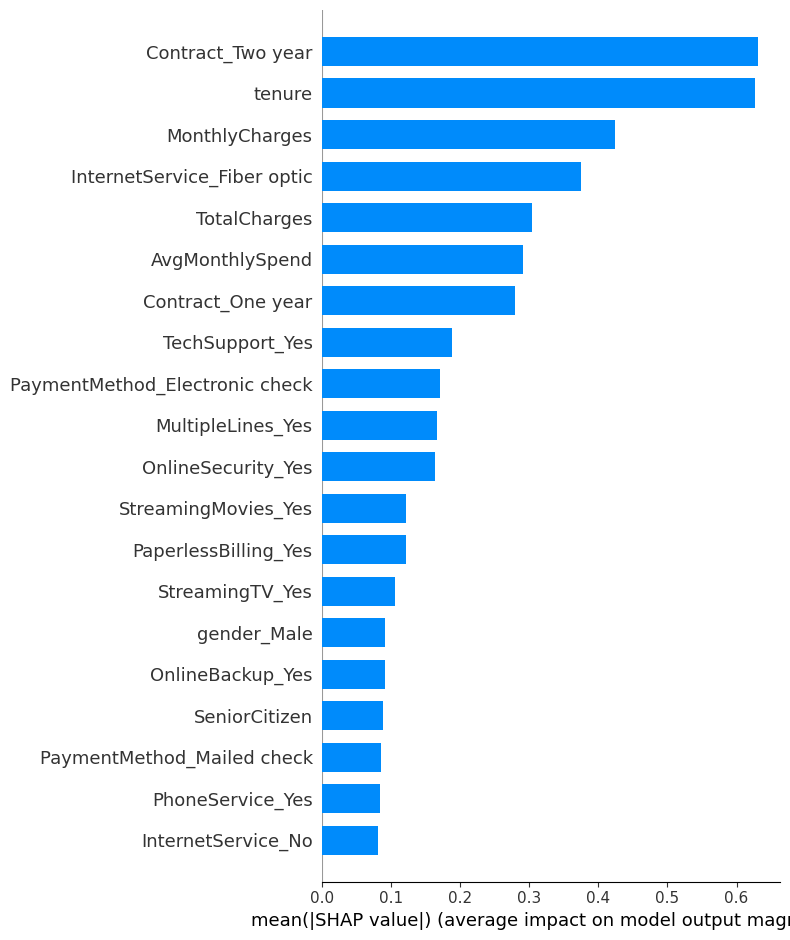

In [12]:
print("10. MODEL EXPLAINABILITY WITH SHAP")
explainer = shap.TreeExplainer(models["XGBoost"])
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")


In [13]:
print("11. FINDING THE BEST MODEL")
# Display results again
print("\nModel Performance Comparison:")
print(results_df.round(4))

# Find best model based on different metrics
print("\n" + "="*60)
print("Best Model by Different Metrics:")
print("="*60)
for metric in results_df.columns:
    best_model_name = results_df[metric].idxmax()
    best_score = results_df[metric].max()
    print(f"{metric:15s}: {best_model_name:20s} ({best_score:.4f})")

# Overall best model (using F1 score as primary metric for imbalanced data)
best_model_name = results_df['F1'].idxmax()
print("\n" + "="*60)
print(f"🏆 OVERALL BEST MODEL: {best_model_name}")
print("="*60)
print(f"\nPerformance metrics:")
print(results_df.loc[best_model_name].round(4))

# Store the best model
best_model = models[best_model_name]
print(f"\n✅ Best model stored in variable 'best_model'")

11. FINDING THE BEST MODEL

Model Performance Comparison:
                     Accuracy  Precision  Recall      F1  ROC-AUC
Logistic Regression    0.7929     0.5950  0.5426  0.5676   0.8464
Decision Tree          0.7673     0.5358  0.5312  0.5335   0.7767
Random Forest          0.7986     0.6219  0.5000  0.5543   0.8325
XGBoost                0.7794     0.5682  0.4972  0.5303   0.8111

Best Model by Different Metrics:
Accuracy       : Random Forest        (0.7986)
Precision      : Random Forest        (0.6219)
Recall         : Logistic Regression  (0.5426)
F1             : Logistic Regression  (0.5676)
ROC-AUC        : Logistic Regression  (0.8464)

🏆 OVERALL BEST MODEL: Logistic Regression

Performance metrics:
Accuracy     0.7929
Precision    0.5950
Recall       0.5426
F1           0.5676
ROC-AUC      0.8464
Name: Logistic Regression, dtype: float64

✅ Best model stored in variable 'best_model'


12. CONFUSION MATRIX FOR BEST MODEL


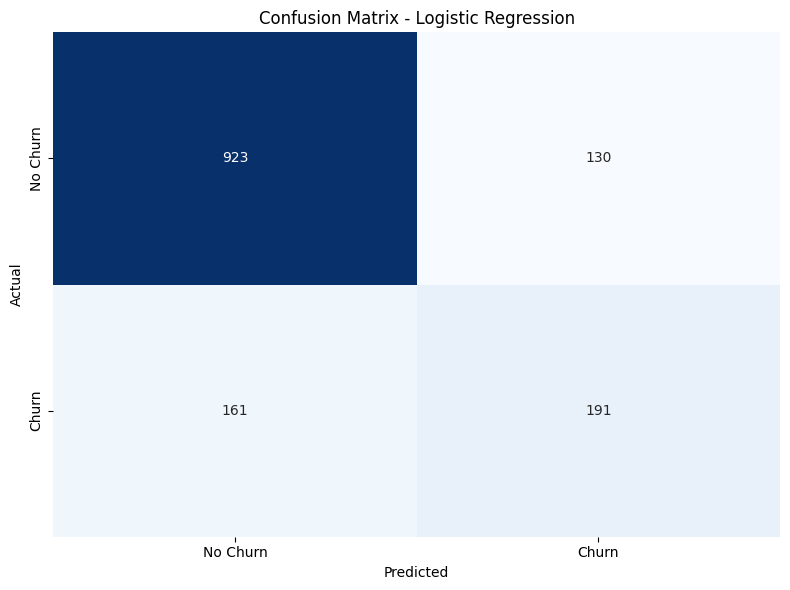


Confusion Matrix for Logistic Regression:
True Negatives (TN): 923
False Positives (FP): 130
False Negatives (FN): 161
True Positives (TP): 191


In [14]:
print("12. CONFUSION MATRIX FOR BEST MODEL")
# Get predictions for best model
y_pred_best = best_model.predict(X_test)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_best)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

# Print detailed metrics
print(f"\nConfusion Matrix for {best_model_name}:")
print(f"True Negatives (TN): {cm[0, 0]}")
print(f"False Positives (FP): {cm[0, 1]}")
print(f"False Negatives (FN): {cm[1, 0]}")
print(f"True Positives (TP): {cm[1, 1]}")

In [15]:
import pickle
from sklearn.linear_model import LogisticRegression

# 1️⃣ Train your best model
best_model = LogisticRegression(max_iter=300)
best_model.fit(X, y)

# 2️⃣ Save the list of features used during training
feature_list = X.columns.tolist()

# 3️⃣ Store both model and features together in one file
model_data = {
    "model": best_model,
    "features": feature_list
}

# 4️⃣ Save using pickle (no need to also use joblib — keep it consistent)
import os
os.makedirs("models", exist_ok=True)

with open("models/best_model.pkl", "wb") as file:
    pickle.dump(model_data, file)

print("✅ Model and feature list saved successfully at models/best_model.pkl")


✅ Model and feature list saved successfully at models/best_model.pkl


In [16]:
# Save cleaned dataframe to CSV
os.makedirs("data", exist_ok=True)
cleaned_file = "data/cleaned_telco_churn.csv"
df.to_csv(cleaned_file, index=False)
print(f"Saved cleaned dataframe ({df.shape[0]} rows, {df.shape[1]} columns) to: {cleaned_file}")

Saved cleaned dataframe (7021 rows, 35 columns) to: data/cleaned_telco_churn.csv


In [17]:
import joblib
import pandas as pd

model = joblib.load("best_model.pkl")

# Get required columns from X_test
required_cols = X_test.columns

# Create a sample dict with all columns, set reasonable defaults
sample_dict = {col: 0 for col in required_cols}
sample_dict["tenure"] = 12
sample_dict["MonthlyCharges"] = 70
sample_dict["TotalCharges"] = 840

# If you want to set some categorical features, e.g.:
sample_dict["gender_Male"] = True
sample_dict["Partner_Yes"] = True
sample_dict["PhoneService_Yes"] = True
sample_dict["Contract_One year"] = True
sample_dict["PaperlessBilling_Yes"] = True

# Calculate AvgMonthlySpend as in feature engineering
sample_dict["AvgMonthlySpend"] = sample_dict["TotalCharges"] / (sample_dict["tenure"] + 1)

# Create DataFrame and ensure correct column order
sample = pd.DataFrame([sample_dict], columns=required_cols)

# Scale numerical features using the same scaler
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
sample[num_cols] = scaler.transform(sample[num_cols])

pred = model.predict(sample)
print("Prediction:", pred)

# Save feature list during training to ensure consistency

# After training your model
import joblib

feature_list = X.columns.tolist()

# Save both model and feature list
joblib.dump((best_model, feature_list), "best_model.pkl")


AttributeError: 'tuple' object has no attribute 'predict'